**In this model, we use a simple Keras CNN to train from scratch**
* We use the Keras ImageDataGenerator library for augmentation and pre-processing
* We implement tensorboard and Checkpoint callbacks for accuracy monitoring

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test_images', 'train_images', 'test.csv']


Specifying Train and Test directories

In [2]:
train_dir = '../input/train_images'
test_dir = '../input/test_images'
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [3]:
len(os.listdir(test_dir))

1928

In [4]:
len(os.listdir(train_dir))

3662

In [5]:
#basic visualizations
train_df.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
train_df["id_code"]=train_df["id_code"].apply(lambda x:x+".png")

In [7]:
train_df.head(5)

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Loading two images from every category

In [8]:
#Lets display one one from each category
import cv2
import matplotlib.pyplot as plt
img = []
img.append(os.path.join(train_dir,'002c21358ce6.png'))
img.append(os.path.join(train_dir,'005b95c28852.png'))

img.append(os.path.join(train_dir,'0124dffecf29.png'))
img.append(os.path.join(train_dir,'00cb6555d108.png'))

img.append(os.path.join(train_dir,'03676c71ed1b.png'))
img.append(os.path.join(train_dir,'03747397839f.png'))

img.append(os.path.join(train_dir,'0104b032c141.png'))
img.append(os.path.join(train_dir,'03c85870824c.png'))


img.append(os.path.join(train_dir,'03a7f4a5786f.png'))
img.append(os.path.join(train_dir,'0318598cfd16.png'))

images = []
for i in range(0,len(img)):
    images.append(plt.imread(img[i]))    

Some simple visualizations

In [9]:
images[0].shape

(1050, 1050, 3)

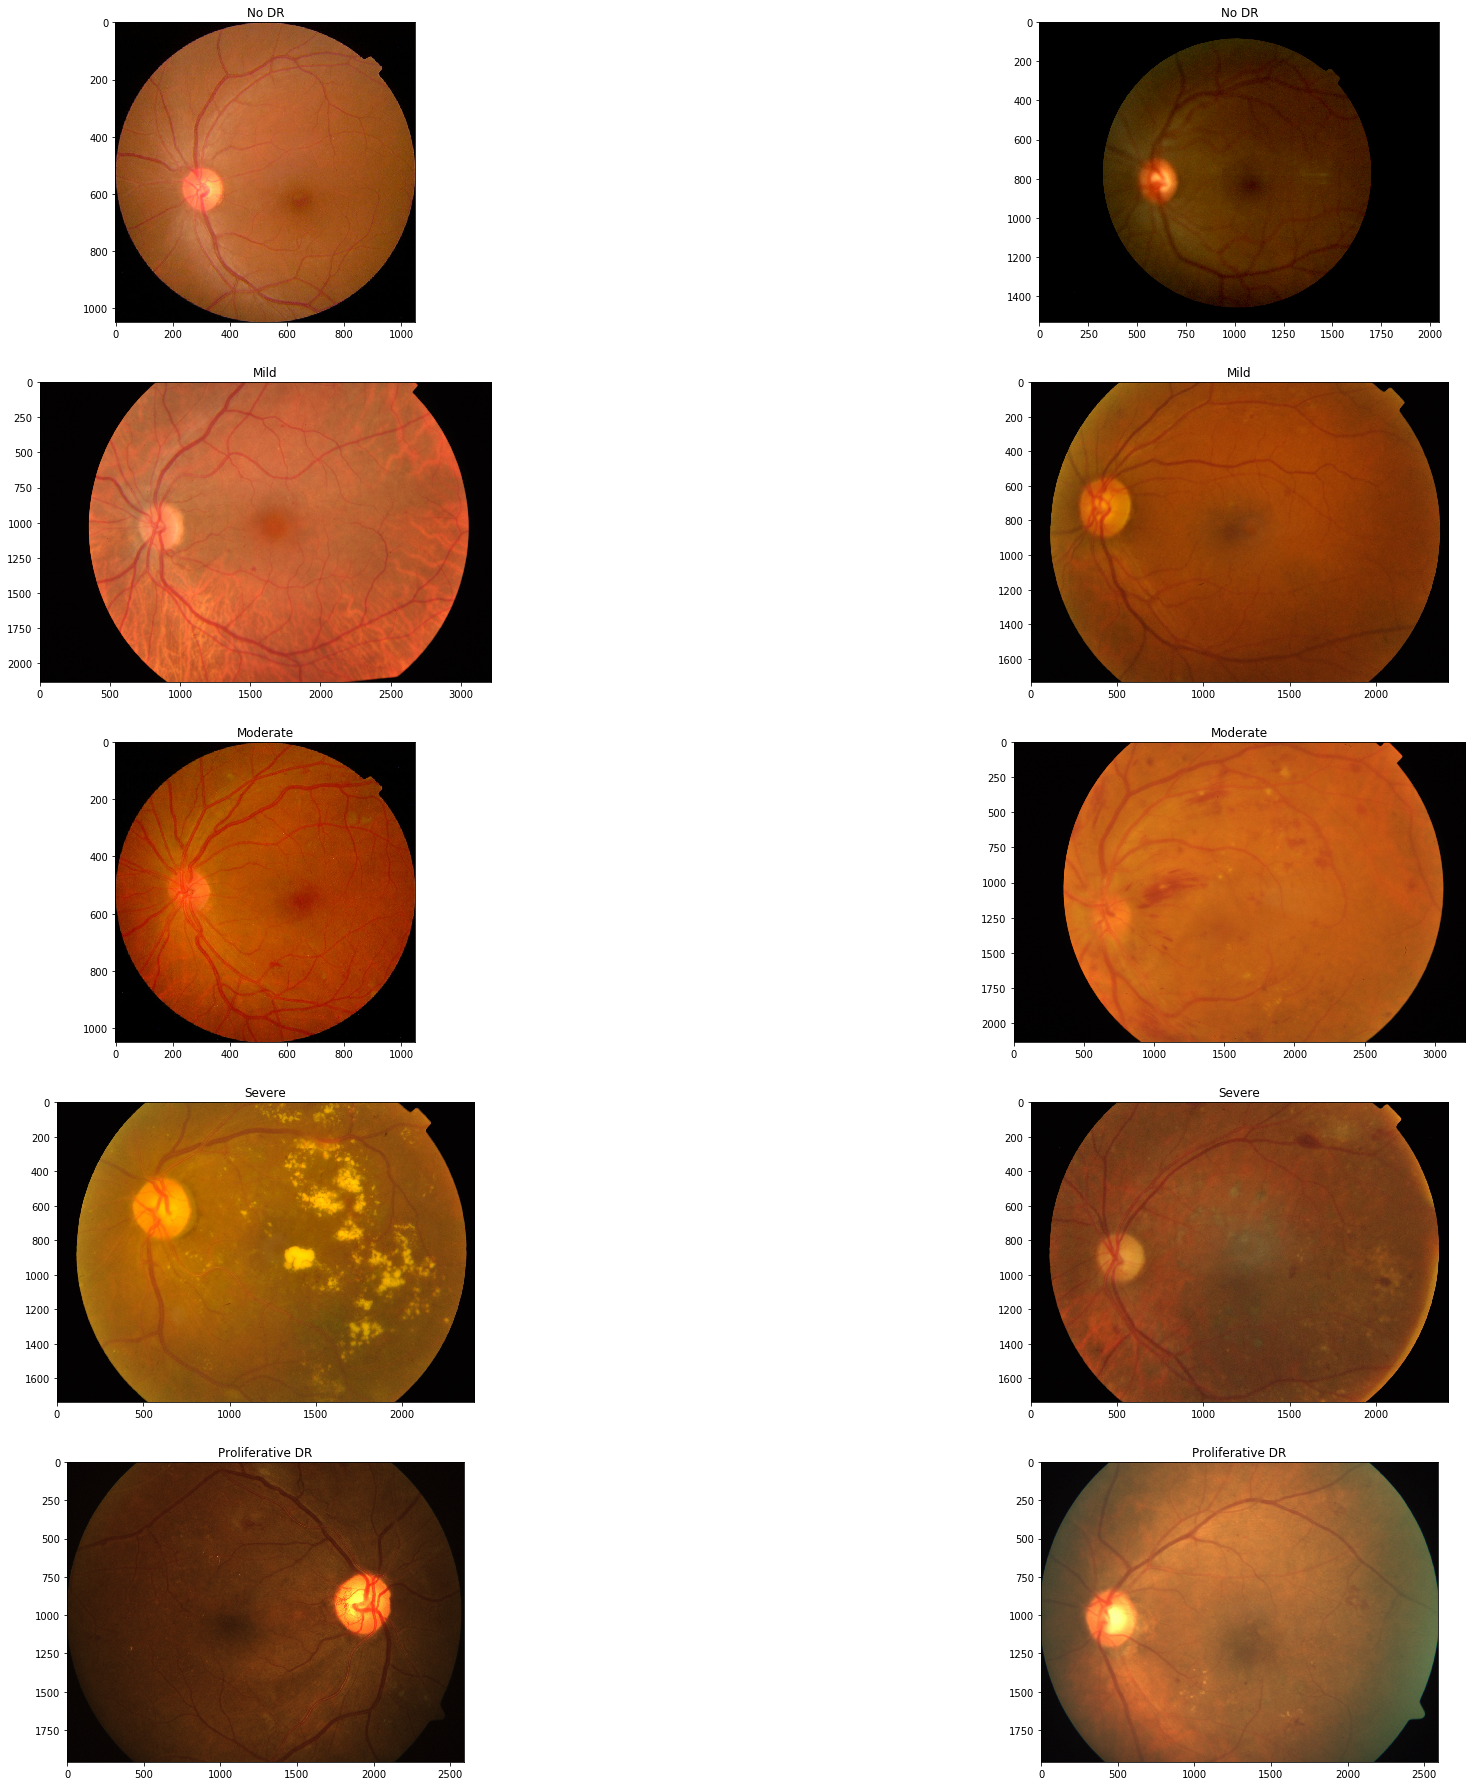

In [10]:
plt.figure(figsize=[32,32])
i = 0
for img_name in images:
    plt.subplot(5, 2,i+1)
    plt.imshow(img_name)
    if(i<2):
        plt.title("No DR")
    elif(i>=2 and i<4):
        plt.title("Mild")
    elif(i>=4 and i<6):
        plt.title("Moderate")
    elif(i>=6 and i<8):
        plt.title("Severe")
    elif(i>=8 and i<10):
        plt.title("Proliferative DR")
    i+=1

Data image augmentation

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  fill_mode = 'nearest',
                                  validation_split = 0.15,
                                  zoom_range = 0.3,
                                  rotation_range = 30)


Using TensorFlow backend.


In [12]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')

In [13]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = train_dir,
    validation_split = 0.2,
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (800,800),
    class_mode = 'categorical',
    batch_size = 32,
    subset = 'training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'id_code',
    y_col = 'diagnosis',
    directory = train_dir,
    class_mode = "categorical",
    batch_size = 32,
    target_size = (800,800),
    subset = "validation"
    )

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.


We make the first layer non-trainable and add a few dense layers along with Flatten() and a Dropout layer to prevent overfitting

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, DenseNet169, DenseNet201
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = (800,800,3)))
model.add(Conv2D(32,(3,3),activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(MaxPool2D(2,2))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation = 'softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 798, 798, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 796, 796, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 398, 398, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 396, 396, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 394, 394, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 197, 197, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 195, 195, 128)     73856     
__________

Implementing callbacks

In [16]:
#some callbacks and tensorboard initialization

callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]


In [17]:
model.compile(loss = 'categorical_crossentropy',optimizer = Adam(),metrics = ['accuracy'])

Training for 80 epochs!

In [18]:
history = model.fit_generator(
    train_generator,
    epochs = 80,
    steps_per_epoch = 20,
    validation_data = val_generator,
    validation_steps = 7,
    callbacks = callbacks
)

Epoch 1/80
20/20 [==============================] - 226s 11s/step - loss: 1.3252 - acc: 0.4844 - val_loss: 1.2923 - val_acc: 0.4598
Epoch 2/80
20/20 [==============================] - 194s 10s/step - loss: 1.2222 - acc: 0.4875 - val_loss: 1.1724 - val_acc: 0.4777
Epoch 3/80
20/20 [==============================] - 201s 10s/step - loss: 1.0971 - acc: 0.5984 - val_loss: 1.0064 - val_acc: 0.6599
Epoch 4/80
20/20 [==============================] - 203s 10s/step - loss: 1.0384 - acc: 0.6141 - val_loss: 1.0530 - val_acc: 0.5938
Epoch 5/80
20/20 [==============================] - 197s 10s/step - loss: 1.0659 - acc: 0.6210 - val_loss: 1.0493 - val_acc: 0.6250
Epoch 6/80
20/20 [==============================] - 200s 10s/step - loss: 0.9603 - acc: 0.6672 - val_loss: 0.9110 - val_acc: 0.6751
Epoch 7/80
20/20 [==============================] - 205s 10s/step - loss: 0.9602 - acc: 0.6516 - val_loss: 1.0923 - val_acc: 0.5714
Epoch 8/80
20/20 [==============================] - 200s 10s/step - loss: 0.

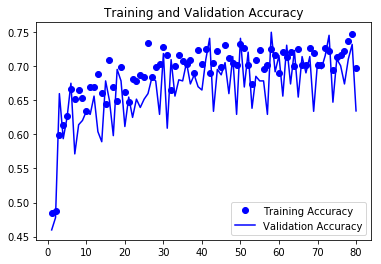

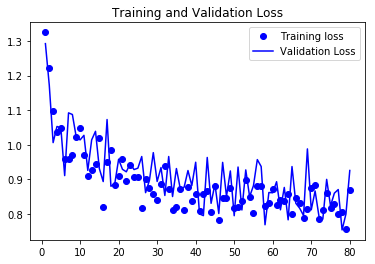

In [19]:
#plotting accuracies and losses
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [20]:
#make predictions on test images

test_datagen = ImageDataGenerator(rescale=1./255)


sample_df = pd.read_csv('../input/sample_submission.csv')

sample_df["id_code"]=sample_df["id_code"].apply(lambda x:x+".png")

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=sample_df,
        directory = test_dir,    
        x_col="id_code",
        target_size = (800,800),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 1928 validated image filenames.


In [21]:
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)

In [22]:
#submission formatting
filenames= test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(preds,axis = 1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

Go ahead and submit!

In [23]:
count = 0
for i in range(0,len(results['diagnosis'])):
    if(results['diagnosis'][i] == 4):
        count+=1
    
count

0